In [1]:
from typing import Callable

import emcee
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [2]:
X = np.linspace(1, 10, 10)
SIGMA = 1


def generate_data(k: float, b: float) -> np.ndarray:
    return k * X + b + np.random.normal(loc=0, scale=SIGMA, size=X.shape)


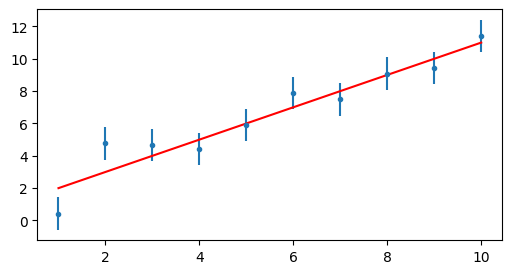

In [3]:
def plot_model(y: np.ndarray, k: float, b: float) -> plt.Axes:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.errorbar(X, y, yerr=SIGMA, fmt=".")
    ax.plot(X, k * X + b, "r")
    return ax


_ = plot_model(y=generate_data(k=1, b=1), k=1, b=1)

In [14]:
def sample(logpost: Callable[[np.ndarray], float], theta_true: np.ndarray, quiet: bool = False) -> np.ndarray:
    n_steps = 2_000
    n_walkers = 128
    n_dim = 2

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walkers,
        ndim=n_dim,
        log_prob_fn=logpost,
    )
    initial_state=theta_true + np.random.normal(loc=0, scale=0.1, size=(n_walkers, 2)) * theta_true

    sampler.run_mcmc(initial_state, nsteps=n_steps, progress=not quiet)
    if not quiet:
        print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

    tau = sampler.get_autocorr_time(quiet=True)
    if not quiet:
        print(f"{tau = }")

    burn_in = 5 * int(tau.max())
    thin = 2 * int(tau.max())
    if not quiet:
        print(f"{burn_in = } {thin = }")

    theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)
    if not quiet:
        print(f"MCMC sample ready, shape: {theta_sample.shape}")

    return theta_sample

In [15]:
def compare_analyses(k: float, b: float, plot: bool = False, quiet: bool = False):
    def display(s: str):
        if quiet:
            return
        print(s)

    z_vals = []
    display(f"k = {k:.3f} b = {b:.3f}")

    y = generate_data(k, b)

    def loglike(theta: np.ndarray) -> float:
        k, b = theta
        return -0.5 * np.sum(((k * X + b - y) / SIGMA) ** 2)

    display("MLE analysis...")

    def negloglike(theta: np.ndarray) -> float:
        return -loglike(theta)

    theta_true = np.array([k, b])
    res = optimize.minimize(
        negloglike,
        x0=theta_true + np.random.normal(loc=0, scale=0.05, size=2) * theta_true,
    )
    display(res)
    k_best, b_best = res.x
    k_err, b_err = np.sqrt(np.diag(res.hess_inv))
    display(f"k = {k_best:.3f} +/- {k_err:.3f}")
    display(f"b = {b_best:.3f} +/- {b_err:.3f}")
    if plot:
        plot_model(y, k_best, b_best)
    z_vals.append([(k - k_best) / k_err, (b - b_best) / b_err])

    def logpost_naive(theta: np.ndarray) -> float:
        return loglike(theta)

    def logpost_jeffreys(theta: np.ndarray) -> float:
        k, _ = theta
        return -np.log(np.abs(k)) + loglike(theta)

    def logpost_geometric(theta: np.ndarray) -> float:
        k, _ = theta
        return -np.log(1 / (1 + k**2)) + loglike(theta)

    for logpost, label in (
        (logpost_naive, "naive"),
        (logpost_jeffreys, "jeffreys"),
        (logpost_geometric, "geometric"),
    ):
        display(f"Bayesian analysis with prior = {label}...")
        s = sample(logpost, theta_true=theta_true, quiet=quiet)
        k_best, b_best = np.mean(s, axis=0)
        k_err, b_err = np.std(s, axis=0)
        display(f"k = {k_best:.3f} +/- {k_err:.3f}")
        display(f"b = {b_best:.3f} +/- {b_err:.3f}")
        if plot:
            plot_model(y, k_best, b_best)
        z_vals.append([(k - k_best) / k_err, (b - b_best) / b_err])

    return np.array(z_vals)

In [16]:
from tqdm import trange

z_sample = None

for _ in trange(100):
    k = np.tan(np.random.random() * np.pi - np.pi / 2)
    b = np.random.random() * 100 - 50
    z = compare_analyses(k=k, b=b, plot=False, quiet=True)
    if z_sample is None:
        z_sample = np.expand_dims(z, axis=2)
    else:
        z_sample = np.concatenate(
            (z_sample, np.expand_dims(z, axis=2)),
            axis=2,
        )

  4%|▍         | 4/100 [00:24<09:44,  6.09s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [96.76251449 93.84994481]
  9%|▉         | 9/100 [00:54<09:15,  6.10s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [85.96807352 80.3683631 ]
 11%|█         | 11/100 [01:07<09:18,  6.27s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [72.09884717 60.43577924]
 17%|█▋        | 17/100 [01:44<08:25,  6.09s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [65.3173149  62.42643325]
 21%|██        | 21/100 [02:09<08:07,  6.17s/it]The chain 

In [18]:
z_sample.shape


(4, 2, 100)

/tmp/ipykernel_7815/1558720158.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


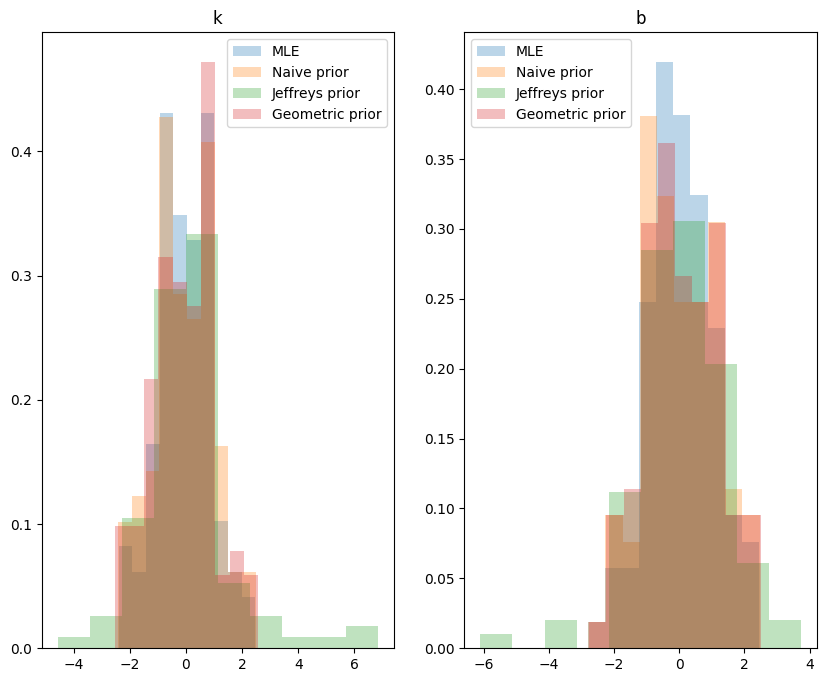

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 8))

for j, param in enumerate(("k", "b")):
    ax: plt.Axes = axes[j]
    ax.set_title(param)
    for i, method in enumerate(
        ("MLE", "Naive prior", "Jeffreys prior", "Geometric prior")
    ):
        data = z_sample[i, j, :]
        ax.hist(data, density=True, label=method, alpha=0.3)
    ax.legend()

fig.show()